# TP 2 : Linear regression



In [71]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

### 1) For the first question, we load a standard dataset from sklearn.datasets named fetch_california_housing. This dataset has only $p = 8$ variables.

#### a) Estimate the coefficients with the expression of the normal equations seen in class. Code two functions to compute the MSE and the R2 coefficient and compare them with the version of sklearn for the train and the test sets.

In [72]:
def compute_mse(y, y_hat):
    return np.mean((y - y_hat)**2)


def compute_r2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)


# Load the California housing dataset
data = fetch_california_housing()
X = data.data
y = data.target

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Estimate the coefficients using the normal equations
coefficients = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
y_train_pred = X_train @ coefficients
y_test_pred = X_test @ coefficients

# Print the results
print("MSE (Train) - Compute:", compute_mse(y_train, y_train_pred))
print("MSE (Train) - Sklearn:", mean_squared_error(y_train, y_train_pred))
print("MSE (Test)  - Compute:", compute_mse(y_test, y_test_pred))
print("MSE (Test)  - Sklearn:", mean_squared_error(y_test, y_test_pred))
print("R2 (Train)  - Compute:", compute_r2(y_train, y_train_pred))
print("R2 (Train)  - Sklearn:", r2_score(y_train, y_train_pred))
print("R2 (Test)   - Compute:", compute_r2(y_test, y_test_pred))
print("R2 (Test)   - Sklearn:", r2_score(y_test, y_test_pred))

MSE (Train) - Compute: 0.5972162225084695
MSE (Train) - Sklearn: 0.5972162225084695
MSE (Test)  - Compute: 0.626459441623385
MSE (Test)  - Sklearn: 0.626459441623385
R2 (Train)  - Compute: 0.5525291345924784
R2 (Train)  - Sklearn: 0.5525291345924784
R2 (Test)   - Compute: 0.5260739633022973
R2 (Test)   - Sklearn: 0.5260739633022973


#### b) Finally, give the confidence intervals at level 99% for all the coefficients coding the expression for the CI seen in session 3.

In [73]:
# Calculate the standard error of the coefficients
standard_deviation2 = np.sum((y_train - y_train_pred)**2)/(X_train.shape[0] - X_train.shape[1] - 1)
standard_error = np.sqrt(standard_deviation2 * np.diagonal(np.linalg.inv(X_train.T @ X_train)))

# Calculate the t-value for a 99% confidence level
alpha = 1 - 0.99
t_value = stats.t.ppf(1 - alpha/2, df=X_train.shape[0] - (X_train.shape[1]+1))

# Calculate the confidence intervals
confidence_intervals = np.column_stack(
    (coefficients - t_value * standard_error, coefficients + t_value * standard_error))

# Print the confidence intervals
for i, interval in enumerate(confidence_intervals):
    print(f"Coefficient {i+1}: [{interval[0]:.2E} , {interval[1]:.2E}]")

Coefficient 1: [5.04E-01 , 5.30E-01]
Coefficient 2: [1.45E-02 , 1.72E-02]
Coefficient 3: [-1.98E-01 , -1.62E-01]
Coefficient 4: [7.62E-01 , 9.37E-01]
Coefficient 5: [-9.93E-06 , 1.99E-05]
Coefficient 6: [-8.41E-03 , -3.58E-03]
Coefficient 7: [-7.33E-02 , -5.21E-02]
Coefficient 8: [-1.93E-02 , -1.26E-02]


### 2) For the rest of the TP, we use the dataset in eCampus data. Load and preprocess the data:

#### a) Separate the data in train and test sets: save one fourth of the data as testing train_test_split from sklearn.model_selection with the random seed set to 0 and standardize both the training and testing sets using the fit_transform and transform functions in sklearn.preprocessing.StandardScaler.

In [74]:
# Import the data
df = pd.read_csv("data.csv", header=None)

X = df.iloc[:, 0:-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.25)

# Standardize training and test sets
# For X and y the scaler is fitted on the training set
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

#### b) Fit a regular OLS

In [75]:
model = LinearRegression().fit(X_train, y_train)

## Variable selection

### 3) Program the method of forward variable selection based on hypothesis tests for regression coefﬁcients. This method starts from an empty set of variables $S$ and at each iteration selects one variable relevant for predicting $y$ and includes it in the set $S$. It runs until a halting condition is met. The coding process is as follows :

#### a) Develop a function that, given a dataset $X \in R^{n \times p}$ and $y$, ﬁts $p$ linear regression models, each using only feature $X_j$ to predict $y$. For each model, conduct a test of no eﬀect, as discussed in session 3, and compute the p-value of the test. This function should return the coeﬃcient with the smallest p-value. Explain the signiﬁcance of the p-value in this context.

In [76]:
def forward_variable_selection(X, y):
    n, p = X.shape

    min_p_value, index = np.inf, None
    for j in range(p):
        X_selected = X[:, j].reshape(-1, 1)

        coefficients = np.linalg.inv(
            X_selected.T @ X_selected) @ X_selected.T @ y
        y_pred = X_selected @ coefficients
        standard_deviation2 = np.sum((y - y_pred)**2) / (n - 1)
        standard_error = np.sqrt(np.diagonal(np.linalg.inv(
            X_selected.T @ X_selected)) * standard_deviation2)
        t_value = abs(coefficients[0, 0]) / standard_error[0]
        p_value = 2 * (1 - stats.t.cdf(t_value, df=n-1))

        if p_value < min_p_value:
            min_p_value = p_value
            index = j
    return index, min_p_value


index, p_value = forward_variable_selection(X_train, y_train)
print(f"Selected index: {index}, p-value: {p_value:.2E}")

Selected index: 34, p-value: 0.00E+00


A small p-value (typically ≤ 0.05) indicates strong evidence that the slope is non-zero, meaning the predictor variable does have an effect on the response variable. A larger p-value suggests that changes in the predictor variable are not associated with changes in the response variable.

#### b) Apply the function iteratively. At each iteration, select the feature $X_f$ with the smallest p-value and:
##### i. Include it in the set $S$.
##### ii. Remove it from $X$.
##### iii. Subtract from $y$ the residuals of the model ﬁt with feature $X_f$. Elaborate on the reason for subtracting the residuals

#### c) Add a halting condition to the algorithm: Stop adding features to the set $S$ when the p-value exceeds 0.05. Plot the p-values for every coeﬃcient for the ﬁrst 5 iterations (all in the same plot).

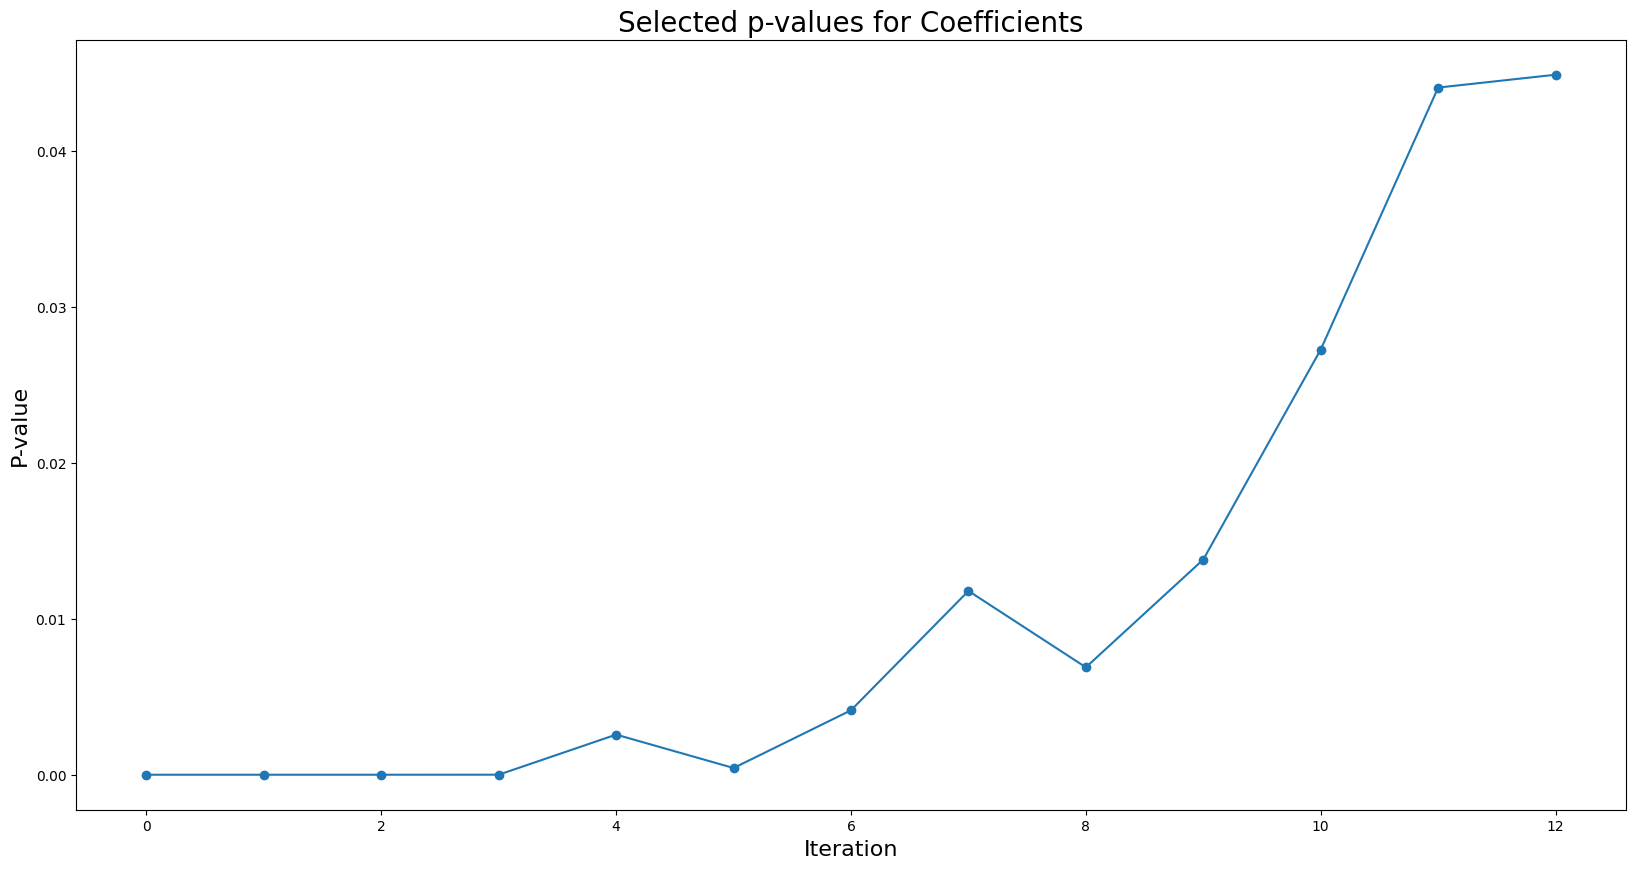

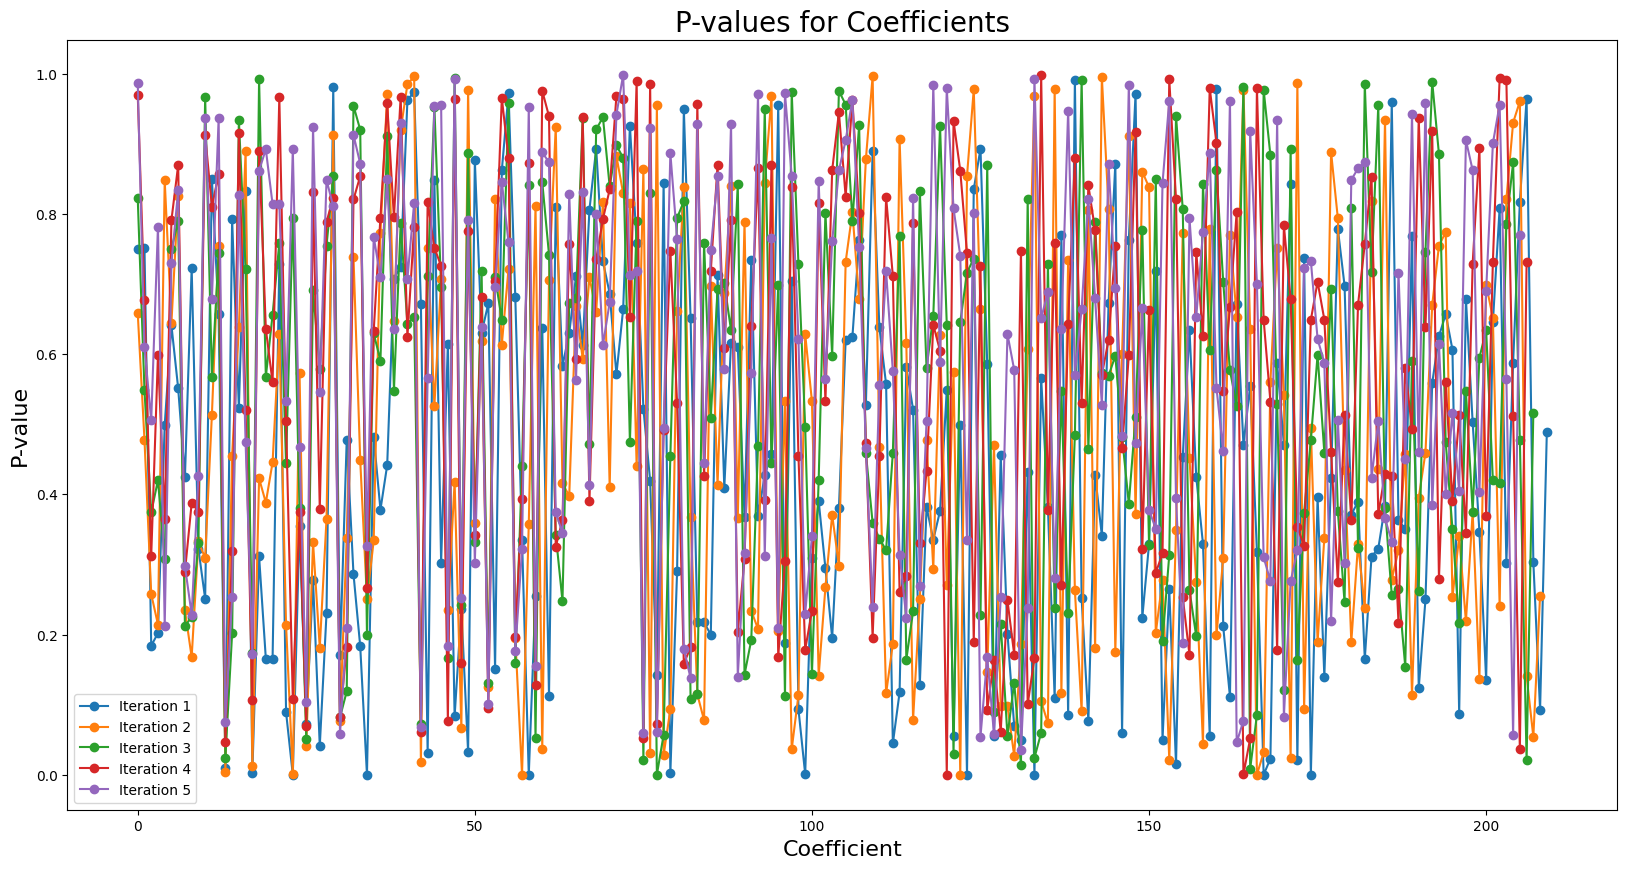

In [77]:


# Get the index of the target column in the matrix
def get_column_index(matrix, target_column):
    for i, column in enumerate(matrix.T):
        if np.array_equal(column, target_column):
            return i


def forward_variable_selection_indexes(X, y):

    X_copy = X.copy()
    y_copy = y.copy()

    total_p_values = []
    selected_features = []
    p_values = []
    p_value = 0

    while p_value < 0.05:
        n, p = X_copy.shape
        total_p_values.append([])

        # get all p-values for the features
        for j in range(p):
            X_selected = X_copy[:, j].reshape(-1, 1)

            coefficients = np.linalg.inv(
                X_selected.T @ X_selected) @ X_selected.T @ y_copy
            y_pred = X_selected @ coefficients
            standard_deviation2 = np.sum((y_train - y_pred)**2) / (n - 2)
            standard_error = np.sqrt(np.diagonal(np.linalg.inv(
                X_selected.T @ X_selected)) * standard_deviation2)
            t_value = abs(coefficients[0]) / standard_error[0]
            total_p_values[-1].append(2 * (1 - stats.t.cdf(t_value, df=n-1)))

        index, p_value = forward_variable_selection(X_copy, y_copy)
        p_values.append(p_value)

        X_selected = X_copy[:, index].reshape(-1, 1)
        selected_features.append(get_column_index(X, X_copy[:, index]))

        # Remove selected feature from X
        X_copy = np.delete(X_copy, index, axis=1)

        coefficients = np.linalg.inv(X_selected.T @ X_selected) @ X_selected.T @ y_copy
        y_pred = X_selected @ coefficients
        y_copy = y_copy - y_pred

    p_values.pop()
    selected_features.pop()

    return selected_features, p_values, total_p_values

_, p_values, total_p_values = forward_variable_selection_indexes(X_train, y_train)

# Plot p-values
plt.figure(figsize=(20, 10))
plt.plot(range(len(p_values)), p_values[:], marker='o')
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('P-value', fontsize=16)
plt.title('Selected p-values for Coefficients', fontsize=20)

plt.figure(figsize=(20, 10))
for i in range(5):
    plt.plot(range(
        len(total_p_values[i])), total_p_values[i], marker='o', label=f"Iteration {i+1}")
plt.xlabel('Coefficient', fontsize=16)
plt.ylabel('P-value', fontsize=16)
plt.title('P-values for Coefficients', fontsize=20)
plt.legend()

plt.show()

## Extensions
### 4) Run ridge regression using scikit-learn on the training set. Run the code for 30 diﬀerent values of the penalty parameter, which should be on a logarithmic scale between $10^{-1}$ and $10^6$. Display two subplots at the end:
#### (a) The ﬁrst subplot should show the evolution of the coeﬃcients for each diﬀerent value of the penalty parameter.
#### (b) The second subplot should display the evolution of the R-squared coeﬃcient at each of the 30 iterations.

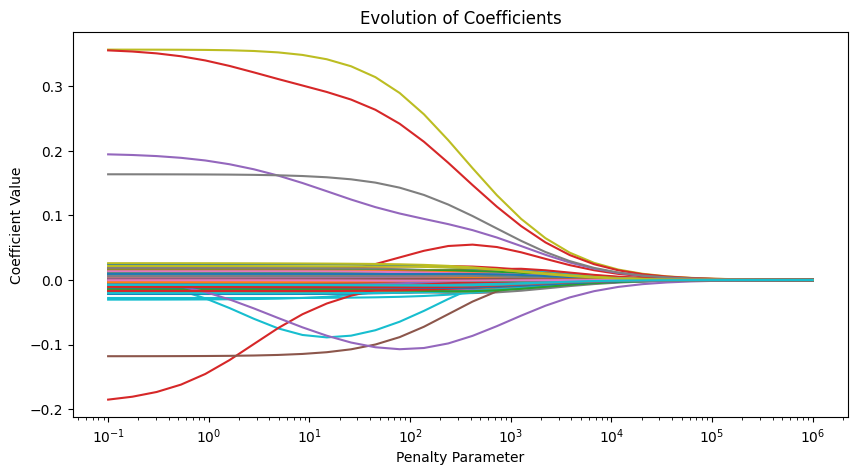

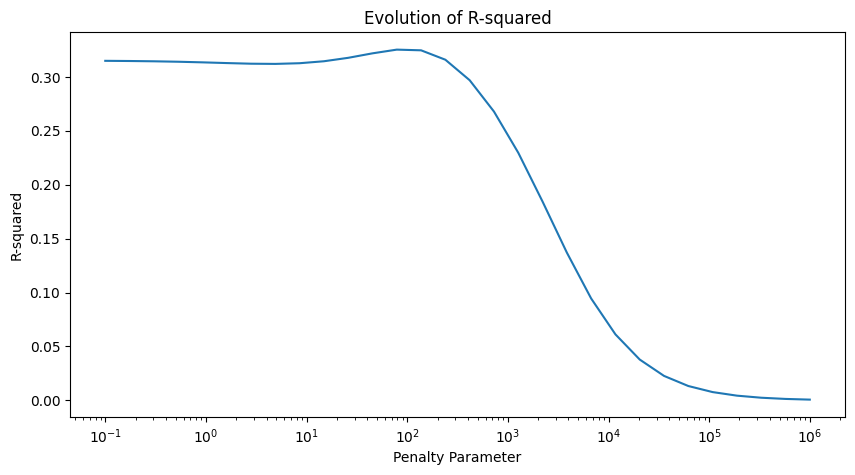

In [78]:
# Define the range of penalty parameters
penalty_params = np.logspace(-1, 6, num=30)

# Initialize lists to store coefficients and R-squared values
coefficients = []
r2_scores = []

# Perform ridge regression for each penalty parameter
for alpha in penalty_params:
    # Create and fit the ridge regression model
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)

    # Store the coefficients and R-squared value
    coefficients.append(ridge.coef_)
    r2_scores.append(r2_score(y_test, ridge.predict(X_test)))

# Convert the coefficients list to a numpy array
coefficients = np.array(coefficients)

# Plot the evolution of coefficients
plt.figure(figsize=(10, 5))
for i in range(coefficients.shape[1]):
    plt.plot(penalty_params, coefficients[:, i], label=f'Coefficient {i+1}')
plt.xscale('log')
plt.xlabel('Penalty Parameter')
plt.ylabel('Coefficient Value')
plt.title('Evolution of Coefficients')
plt.show()

# Plot the evolution of R-squared values
plt.figure(figsize=(10, 5))
plt.plot(penalty_params, r2_scores)
plt.xscale('log')
plt.xlabel('Penalty Parameter')
plt.ylabel('R-squared')
plt.title('Evolution of R-squared')
plt.show()

Since we are going to perform similar tasks for Lasso and Elastic Net, it is mandatory to write this code as an independent function that can be parameterized for each speciﬁc case.
#### 5) Run the code for Lasso as explained in Point 4. Run the code for 30 diﬀerent values of the penalty parameter, which should be on a logarithmic scale between $10^{-3}$ and $10^2$.

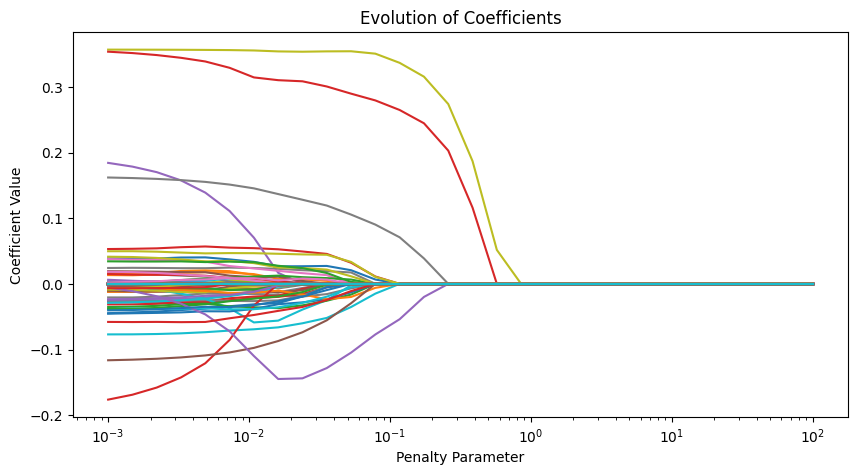

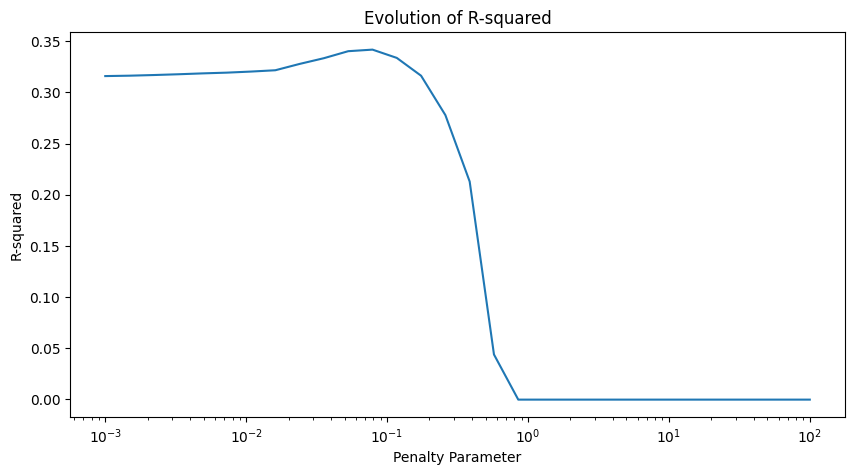

In [79]:
def run_lasso(X_train, X_test, y_train, y_test, penalty_params):
    # Initialize lists to store coefficients and R-squared values
    coefficients = []
    r2_scores = []

    # Perform Lasso regression for each penalty parameter
    for alpha in penalty_params:
        # Create and fit the Lasso regression model
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)

        # Store the coefficients and R-squared value
        coefficients.append(lasso.coef_)
        r2_scores.append(r2_score(y_test, lasso.predict(X_test)))

    # Convert the coefficients list to a numpy array
    coefficients = np.array(coefficients)

    # Plot the evolution of coefficients
    plt.figure(figsize=(10, 5))
    for i in range(coefficients.shape[1]):
        plt.plot(penalty_params,
                 coefficients[:, i], label=f'Coefficient {i+1}')
    plt.xscale('log')
    plt.xlabel('Penalty Parameter')
    plt.ylabel('Coefficient Value')
    plt.title('Evolution of Coefficients')
    plt.show()

    # Plot the evolution of R-squared values
    plt.figure(figsize=(10, 5))
    plt.plot(penalty_params, r2_scores)
    plt.xscale('log')
    plt.xlabel('Penalty Parameter')
    plt.ylabel('R-squared')
    plt.title('Evolution of R-squared')
    plt.show()


# Define the range of penalty parameters
penalty_params = np.logspace(-3, 2, num=30)

# Call the function with the appropriate arguments
run_lasso(X_train, X_test, y_train, y_test, penalty_params)

#### Run the code for ElasticNet as explained in Point 4. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between $10^{-3}$ and $10^2$.

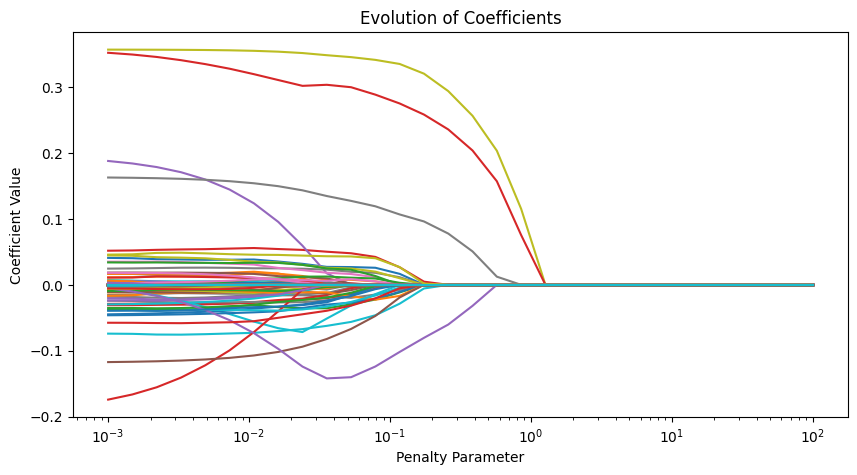

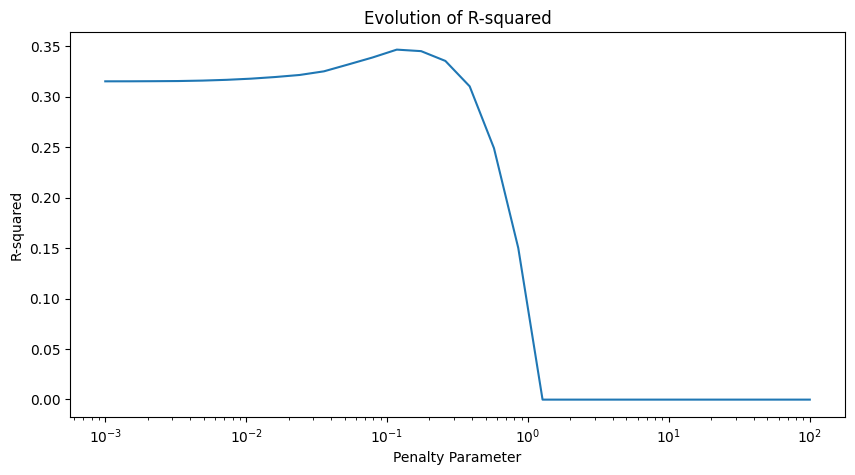

In [80]:
def run_elastic_net(X_train, X_test, y_train, y_test, penalty_params):
    # Initialize lists to store coefficients and R-squared values
    coefficients = []
    r2_scores = []

    # Perform ElasticNet regression for each penalty parameter
    for alpha in penalty_params:
        # Create and fit the ElasticNet regression model
        elastic_net = ElasticNet(alpha=alpha)
        elastic_net.fit(X_train, y_train)

        # Store the coefficients and R-squared value
        coefficients.append(elastic_net.coef_)
        r2_scores.append(r2_score(y_test, elastic_net.predict(X_test)))

    # Convert the coefficients list to a numpy array
    coefficients = np.array(coefficients)

    # Plot the evolution of coefficients
    plt.figure(figsize=(10, 5))
    for i in range(coefficients.shape[1]):
        plt.plot(penalty_params,
                 coefficients[:, i], label=f'Coefficient {i+1}')
    plt.xscale('log')
    plt.xlabel('Penalty Parameter')
    plt.ylabel('Coefficient Value')
    plt.title('Evolution of Coefficients')
    plt.show()

    # Plot the evolution of R-squared values
    plt.figure(figsize=(10, 5))
    plt.plot(penalty_params, r2_scores)
    plt.xscale('log')
    plt.xlabel('Penalty Parameter')
    plt.ylabel('R-squared')
    plt.title('Evolution of R-squared')
    plt.show()


# Define the range of penalty parameters
penalty_params = np.logspace(-3, 2, num=30)

# Call the function with the appropriate arguments
run_elastic_net(X_train, X_test, y_train, y_test, penalty_params)

### 7) Compute the singular value decomposition of the covariance matrix. For consistency in the notation use $U, s, V = SVD(X^{\top} X)$.
#### a) Plot a heatmap of the covariance matrix.

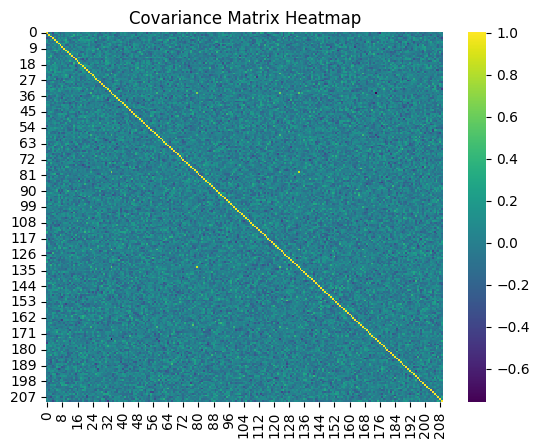

In [81]:
# Compute the covariance matrix
cov_matrix = np.cov(X_train.T)

# Plot the heatmap
sns.heatmap(cov_matrix, cmap='viridis', fmt=".2f")
plt.title('Covariance Matrix Heatmap')
plt.show()

#### b) Compute the PCA for the data using the SVD.

In [82]:
# Subtract the mean from each feature
X_centered = X_train - np.mean(X_train, axis=0)

# Perform singular value decomposition (SVD)
U, s, V = np.linalg.svd(X_centered.T @ X_centered)

# Sort the singular values and corresponding eigenvectors
sorted_indices = np.argsort(s)[::-1]
sorted_singular_values = s[sorted_indices]
sorted_eigenvectors = V.T[sorted_indices]

# Select the top k eigenvectors
projection_matrix = sorted_eigenvectors[:, :]

# Project the centered dataset onto the projection matrix
X_pca = X_centered @ projection_matrix

#### c) Plot the amount of variance explained by the ﬁrst $k$ components for $k \in {2..p}$. How many variables do we need to explain more than 90% of the variance?

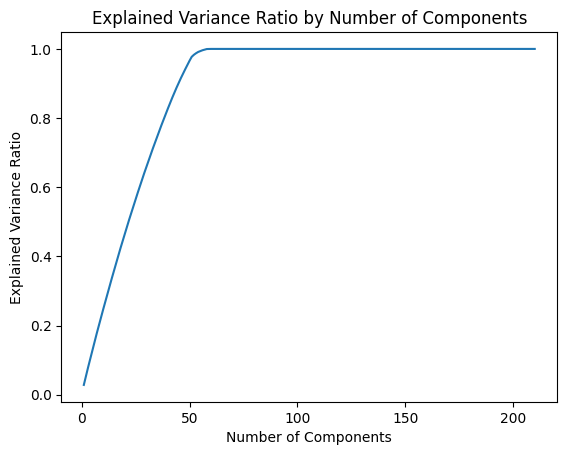

Number of components needed to explain more than 90% of the variance: 45


In [83]:
# Compute the explained variance ratio
explained_variance_ratio = np.cumsum(sorted_singular_values) / np.sum(sorted_singular_values)

# Plot the explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.show()

# Find the number of components needed to explain more than 90% of the variance
num_components = np.argmax(explained_variance_ratio > 0.9) + 1
print(f"Number of components needed to explain more than 90% of the variance: {num_components}")

#### d) Plot the projected data with $k = 2$ using as color the value of $y$ and interpret the plot.

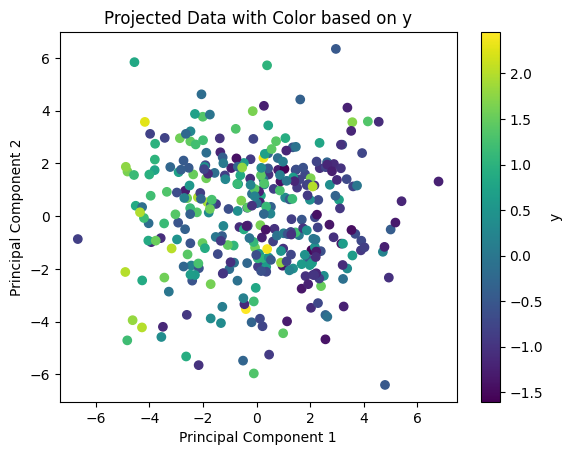

In [84]:
# Plot the projected data with color based on y
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projected Data with Color based on y')
plt.colorbar(label='y')
plt.show()

We can observe that the value of y is correlated with the first component of the PCA. The value of y increases as the first component increases, as there are blue dots in the left side of the plot and red dots in the right side of the plot.

#### e) Plot the the two ﬁrst principal directions.

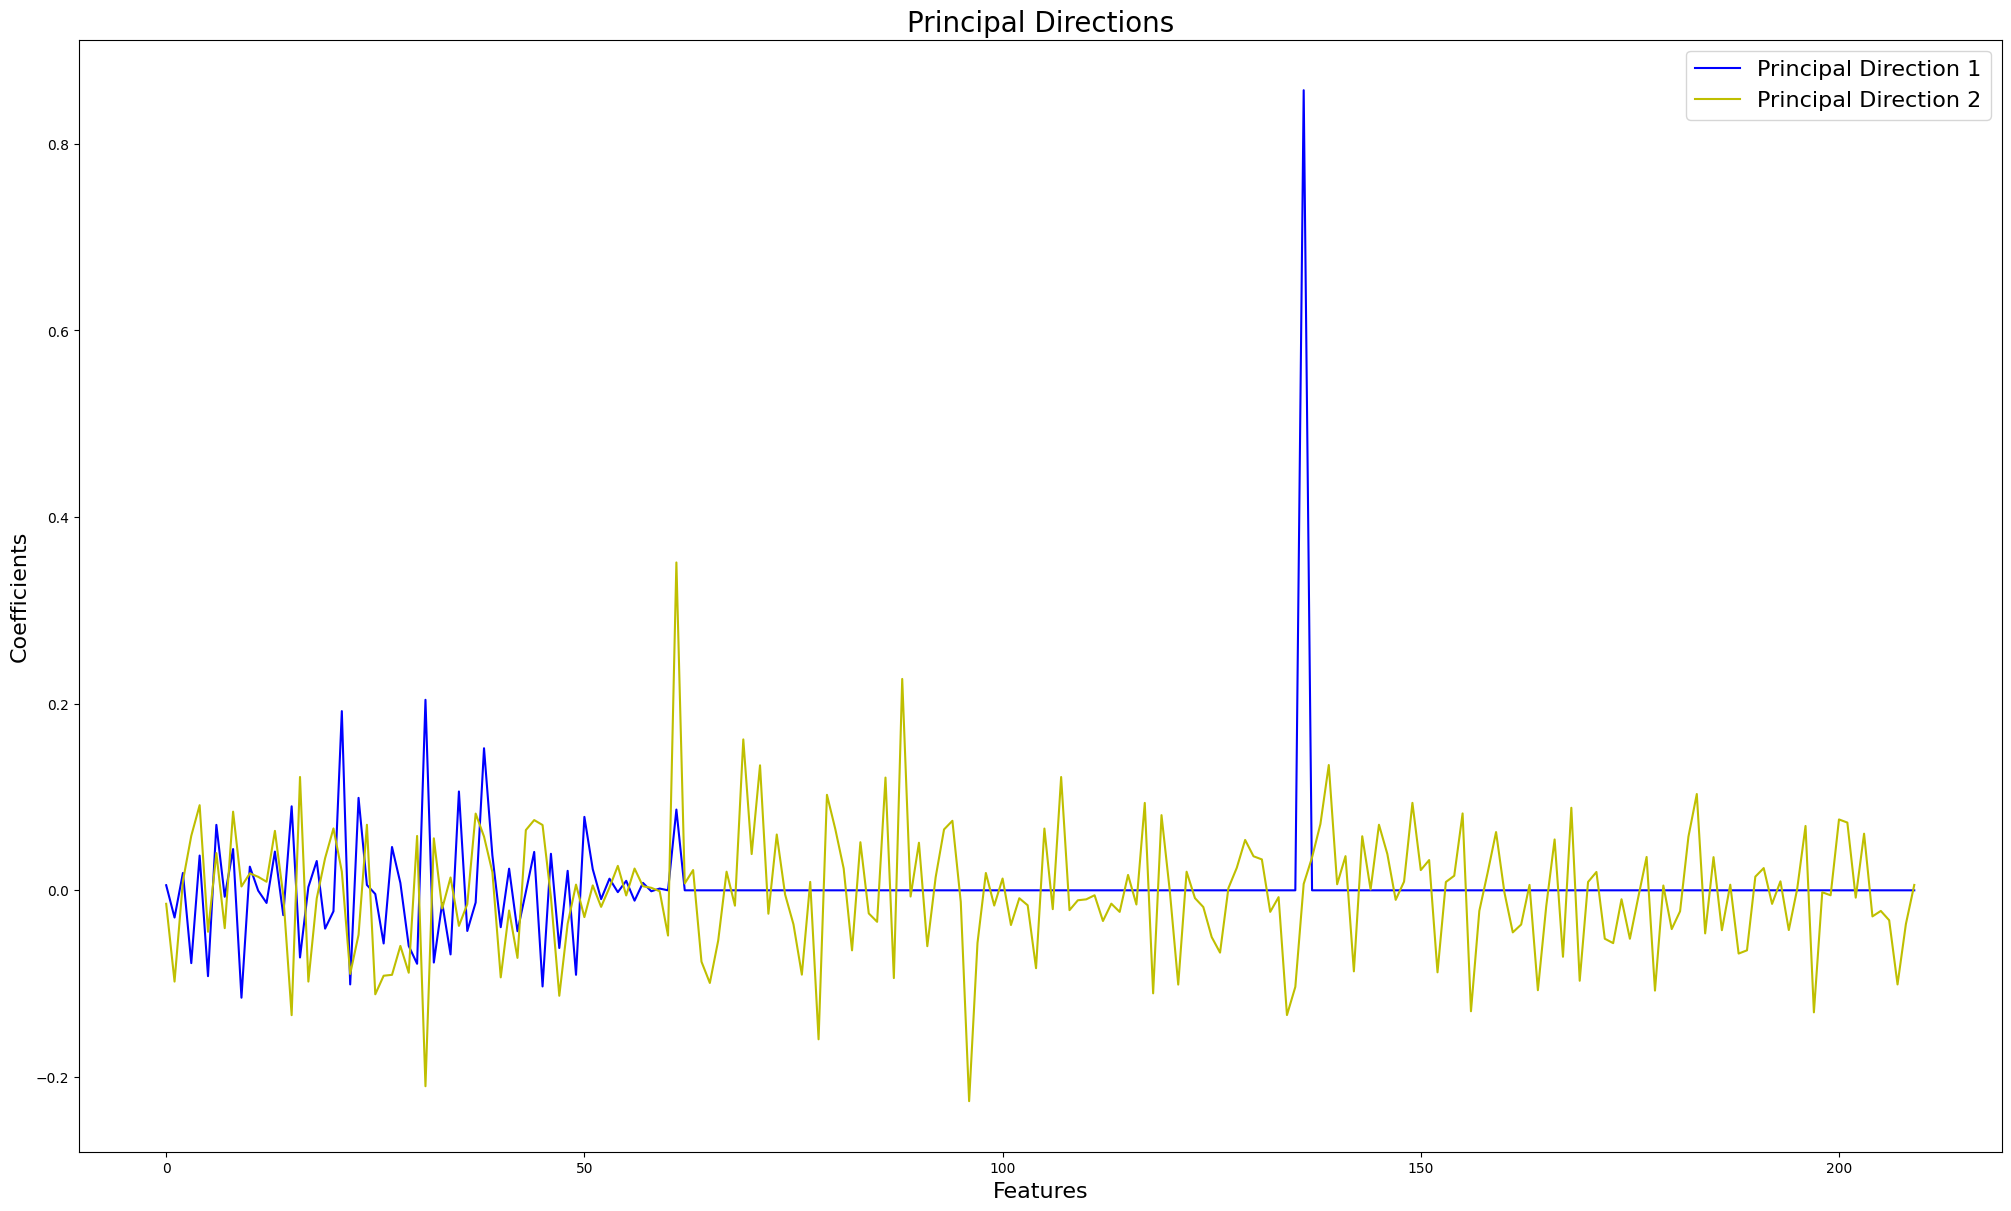

In [85]:
# Plot the first two principal directions
plt.figure(figsize=(20, 12),constrained_layout=True)
plt.plot(range(len(sorted_eigenvectors[0, :])),
         sorted_eigenvectors[0, :], color='b', label='Principal Direction 1')
plt.plot(range(len(sorted_eigenvectors[1, :])),
         sorted_eigenvectors[1, :], color='y', label='Principal Direction 2')
plt.xlabel('Features',  fontsize=16)
plt.ylabel('Coefficients',  fontsize=16)
plt.title('Principal Directions',  fontsize=20)
plt.legend( fontsize=16)
plt.show()

We can see that for the first direction, one coordinate is dominant, whereas for the second direction, the coordinates are more balanced.

#### f) Run OLS on the projected data (PCR) using $k$ components for $k < 50$. Select the $k$ that returns the best score of the OLS model and plot the evolution of the scores with $k$.

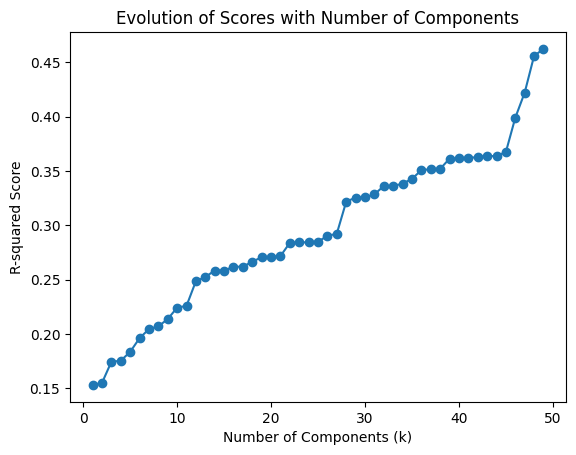

The best k value is 49 with a score of 0.46246430918642756


In [86]:
# Initialize variables
k_values = range(1,50)
scores = []

# Perform OLS for each k value
for k in k_values:
    # Select the top k eigenvectors
    projection_matrix = sorted_eigenvectors[:, :k]

    # Project the centered dataset onto the projection matrix
    X_pca = X_centered @ projection_matrix

    # Fit the OLS model
    ols = LinearRegression()
    ols.fit(X_pca, y_train)

    # Predict the target variable
    y_pred = ols.predict(X_pca)

    # Calculate the R-squared score
    score = r2_score(y_train, y_pred)
    scores.append(score)

# Find the k value that returns the best score
best_k = k_values[np.argmax(scores)]
best_score = max(scores)

# Plot the evolution of scores with k
plt.plot(k_values, scores, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('R-squared Score')
plt.title('Evolution of Scores with Number of Components')
plt.show()

print(f"The best k value is {best_k} with a score of {best_score}")

### 8) Summarize the results of the models and elaborate in their main characteristics. Plot all the training and testing errors for all the models considered and elaborate on the results.

To summarize the results of the models and elaborate on their main characteristics, we have considered several models in this Jupyter Notebook. Here are the main characteristics and results of each model:

1. Forward Variable Selection (FVS):
   - This model performs forward variable selection to select the most relevant features for prediction.
   - It iteratively selects features based on their p-values until a stopping criterion (p-value < 0.05) is met.
   - The selected features and their corresponding p-values are stored.

2. Ridge Regression:
   - This model performs ridge regression using scikit-learn on the training set.
   - It runs the code for 30 different values of the penalty parameter, which are on a logarithmic scale between $10^{-1}$ and $10^6$.

3. Lasso Regression:
   - This model performs Lasso regression using scikit-learn on the training set.
   - It runs the code for 30 different values of the penalty parameter, which are on a logarithmic scale between $10^{-3}$ and $10^2$.

4. ElasticNet Regression:
   - This model performs ElasticNet regression using scikit-learn on the training set.
   - It runs the code for 30 different values of the penalty parameter, which are on a logarithmic scale between $10^{-3}$ and $10^2$.

5. Principal Component Regression (PCR):
   - This model performs Principal Component Analysis (PCA) using the SVD.
   - This model then performs Ordinary Least Squares (OLS) on the projected data obtained from PCA.


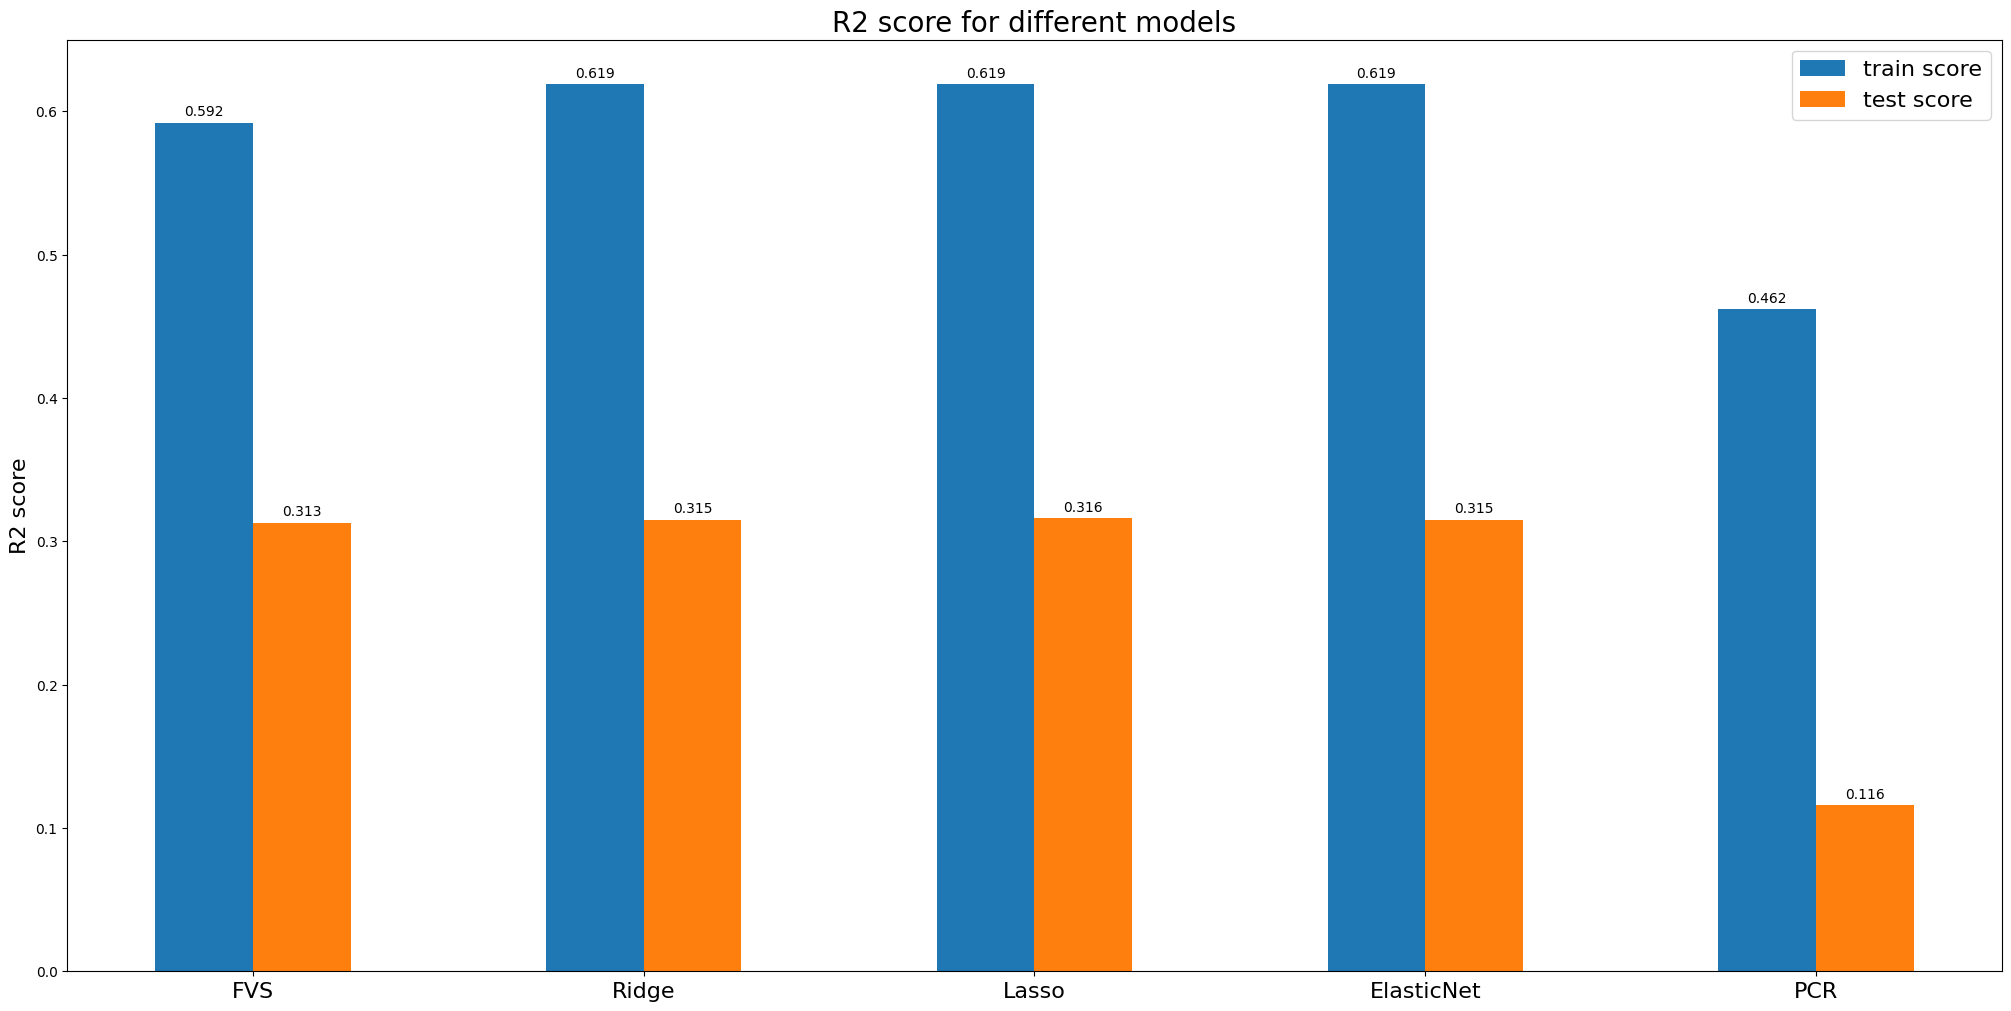

In [87]:
score = {}

## score for forward variable selection

indexes, _, _ = forward_variable_selection_indexes(X_train, y_train)

# Fit Linear regression
linear_reg = LinearRegression()
linear_reg.fit(X_train[:, indexes], y_train)
y_predict_train = linear_reg.predict(X_train[:, indexes])
y_predict_test = linear_reg.predict(X_test[:, indexes])

score['Forward Variable Selection'] = {}
score['Forward Variable Selection']['train'] = r2_score(y_train, y_predict_train)
score['Forward Variable Selection']['test'] = r2_score(y_test, y_predict_test)



## score for Ridge

model = Ridge(np.logspace(-1, 6, 30)[0])
model.fit(X_train, y_train)

score['Ridge'] = {}
score['Ridge']['train'] = r2_score(y_train, model.predict(X_train))
score['Ridge']['test'] = r2_score(y_test, model.predict(X_test))


## score for Lasso

model = Lasso(np.logspace(-3, 2, 30)[0])
model.fit(X_train, y_train)

score['Lasso'] = {}
score['Lasso']['train'] = r2_score(y_train, model.predict(X_train))
score['Lasso']['test'] = r2_score(y_test, model.predict(X_test))



## score for ElasticNet

model = ElasticNet(np.logspace(-3, 2, 30)[0])
model.fit(X_train, y_train)

score['ElasticNet'] = {}
score['ElasticNet']['train'] = r2_score(y_train, model.predict(X_train))
score['ElasticNet']['test'] = r2_score(y_test, model.predict(X_test))



## score for PCR

score['PCR'] = {}
k = 49

## train

X_centered = X_train - np.mean(X_train, axis=0)
U, s, V = np.linalg.svd(X_centered.T @ X_centered)

sorted_indices = np.argsort(s)[::-1]
sorted_singular_values = s[sorted_indices]
sorted_eigenvectors = V.T[sorted_indices]

projection_matrix = sorted_eigenvectors[:, :k]

# Project the centered dataset onto the projection matrix
X_pca = X_centered @ projection_matrix

# Fit the OLS model
ols = LinearRegression()
ols.fit(X_pca, y_train)

# Predict the target variable
y_pred = ols.predict(X_pca)

score['PCR']['train'] = r2_score(y_train, y_pred)


## test

X_centered = X_test - np.mean(X_test, axis=0)

# Project the centered dataset onto the projection matrix
X_pca = X_centered @ projection_matrix

# Predict the target variable
y_pred = ols.predict(X_pca)

score['PCR']['test'] = r2_score(y_test, y_pred)


models = ['FVS', 'Ridge', 'Lasso', 'ElasticNet', 'PCR']

# Create a list of train scores and test scores
train_scores = np.round([score[model]['train'] for model in score],3)
test_scores = np.round([score[model]['test'] for model in score],3)

x = np.arange(len(models))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(20, 10), constrained_layout=True)


rects = ax.bar(x, train_scores, width, label="train score")
ax.bar_label(rects, padding=3)
rects = ax.bar(x + width, test_scores, width, label="test score")
ax.bar_label(rects, padding=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('R2 score', fontsize=16)
ax.set_xticks(x + width/2, models, fontsize=16)
ax.legend(fontsize=16)
ax.set_title('R2 score for different models', fontsize=20)

plt.show()

We can observe that the best models are the Ridge, Lasso and ElasticNet models, as they have the highest R2 score on the train and test sets. The FVS model has a slightly lower R2 score on the train set, but it is still a good model.

Finally, the PCR model has the lowest R2 score on the train and test set, indicating that it is most likely an underfitting model.